# How to access NectarCAM data from the EGI grid directly using the DIRAC API ?

In this short notebook, we will see how to access data stored on the grid using the DIRAC API, without the hassle of first manually downloading them locally.

In order to achieve this, you will obvisouly need a `conda` environment in which all relevant code is installed, such as `ctapipe`, `nectarchain`, but also `CTADIRAC` itself.

This is possible by installing `nectarchain` using `environment-dirac.yml`. Within this environment, you may also need to configure the environment variables `$X509_CERT_DIR`, `$X509_VOMS_DIR` and `$X509_VOMSES`:

```
conda env config vars set X509_CERT_DIR=${CONDA_PREFIX}/etc/grid-security/certificates X509_VOMS_DIR=${CONDA_PREFIX}/etc/grid-security/vomsdir X509_VOMSES=${CONDA_PREFIX}/etc/grid-security/vomses -n nectarchain-dirac
```

You will also need to have an active proxy for EGI, initialized e.g. with:

```
dirac-proxy-init -U -M -g cta_nectarcam
```

You can also check whether you currently have an active proxy with the command `dirac-proxy-info`.

In [1]:
from DIRAC.Interfaces.API.Dirac import Dirac

In [2]:
dirac = Dirac()

In [3]:
dirac.getFile?

Signature: dirac.getFile(lfn, destDir='', printOutput=False)
Docstring:
Retrieve a single file or list of files from Grid storage to the current directory. lfn is the
desired logical file name for the file, fullPath is the local path to the file and diracSE is the
Storage Element name for the upload.  The fileGuid is optional, if not specified a GUID will be
generated on the fly.

Example Usage:

>>> print dirac.getFile('/lhcb/user/p/paterson/myFile.tar.gz')
{'OK': True, 'Value':{'Failed': {},
 'Successful': {'/lhcb/user/p/paterson/test/myFile.tar.gz': '/afs/cern.ch/user/p/paterson/myFile.tar.gz'}}}

:param lfn: Logical File Name (LFN)
:type lfn: string
:param printOutput: Optional flag to print result
:type printOutput: boolean
:returns: S_OK,S_ERROR
File:      ~/local/src/python/anaconda/envs/nectarchain-dirac/lib/python3.8/site-packages/DIRAC/Interfaces/API/Dirac.py
Type:      method


In [4]:
lfns = ['/vo.cta.in2p3.fr/nectarcam/2022/20220411/NectarCAM.Run3169.0000.fits.fz',
        '/vo.cta.in2p3.fr/nectarcam/2022/20220411/NectarCAM.Run3169.0001.fits.fz']

In [5]:
import os
tmpdir = f"/tmp/{os.environ['USER']}/scratch"
if not os.path.isdir(tmpdir):
    print(f'{tmpdir} does not exist yet, I will create it for you')
    os.makedirs(tmpdir)

/tmp/jlenain/scratch does not exist yet, I will create it for you


In [6]:
dirac.getFile(lfn=lfns,destDir=tmpdir,printOutput=True)

{'Failed': {},
 'Successful': {'/vo.cta.in2p3.fr/nectarcam/2022/20220411/NectarCAM.Run3169.0000.fits.fz': '/tmp/jlenain/scratch/NectarCAM.Run3169.0000.fits.fz',
                '/vo.cta.in2p3.fr/nectarcam/2022/20220411/NectarCAM.Run3169.0001.fits.fz': '/tmp/jlenain/scratch/NectarCAM.Run3169.0001.fits.fz'}}


{'OK': True,
 'Value': {'Successful': {'/vo.cta.in2p3.fr/nectarcam/2022/20220411/NectarCAM.Run3169.0000.fits.fz': '/tmp/jlenain/scratch/NectarCAM.Run3169.0000.fits.fz',
   '/vo.cta.in2p3.fr/nectarcam/2022/20220411/NectarCAM.Run3169.0001.fits.fz': '/tmp/jlenain/scratch/NectarCAM.Run3169.0001.fits.fz'},
  'Failed': {}}}

**You are now ready to work with `ctapipe` as usual!**

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from ctapipe.io import EventSource, EventSeeker
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

/home/jlenain/local/src/python/anaconda/envs/nectarchain-dirac/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Seeking event by iterating through events.. (potentially long process)


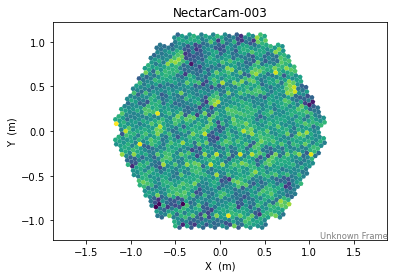

In [8]:
from glob import glob

path = glob(f'{tmpdir}/NectarCAM.*.fits.fz')
path.sort()
reader = EventSource(input_url=path[0])
seeker = EventSeeker(reader)

# Get some event, and display camera charges for the high gain channel (no time window optimization)
evt=seeker.get_event_index(10)
image = evt.r0.tel[0].waveform.sum(axis=2)
camera = CameraGeometry.from_name("NectarCam-003")
disp = CameraDisplay(geometry=camera, image=image[0])